In [ ]:
#睡眠数据集导入

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# 读取模拟数据
df = pd.read_csv("wearable_tech_sleep_quality_1.csv")
df.head()

,Heart_Rate_Variability,Body_Temperature,Movement_During_Sleep,Sleep_Duration_Hours,Sleep_Quality_Score,Caffeine_Intake_mg,Stress_Level,Bedtime_Consistency,Light_Exposure_hours
0,79.934283,37.199678,1.324822,4.638289,1.0,107.624032,2.771837,0.657037,7.933949
1,67.234714,36.962317,1.855481,6.209422,1.0,104.658589,3.738138,0.144464,6.992699
2,82.953771,36.529815,1.207580,6.879592,10.0,0.000000,3.115880,0.642949,7.655250
3,100.460597,36.176532,1.692038,10.331531,1.0,116.990981,3.904008,0.453255,9.429463
4,65.316933,36.849112,0.106385,8.334830,1.0,223.282908,4.571699,0.641492,10.555713


In [13]:
# 定义中英文列名映射关系
column_mapping = {
    'Heart_Rate_Variability': '心率变异性',
    'Body_Temperature': '体温',
    'Movement_During_Sleep': '睡眠期间移动',
    'Sleep_Duration_Hours': '睡眠时长(小时)',
    'Sleep_Quality_Score': '睡眠质量评分',
    'Caffeine_Intake_mg': '咖啡因摄入量(mg)',
    'Stress_Level': '压力水平',
    'Bedtime_Consistency': '就寝时间一致性',
    'Light_Exposure_hours': '光照暴露时间(小时)'
}

# 读取数据并重命名列
df = pd.read_csv("wearable_tech_sleep_quality_1.csv").rename(columns=column_mapping)

# 查看转换后的数据
df.head()

,心率变异性,体温,睡眠期间移动,睡眠时长(小时),睡眠质量评分,咖啡因摄入量(mg),压力水平,就寝时间一致性,光照暴露时间(小时)
0,79.934283,37.199678,1.324822,4.638289,1.0,107.624032,2.771837,0.657037,7.933949
1,67.234714,36.962317,1.855481,6.209422,1.0,104.658589,3.738138,0.144464,6.992699
2,82.953771,36.529815,1.207580,6.879592,10.0,0.000000,3.115880,0.642949,7.655250
3,100.460597,36.176532,1.692038,10.331531,1.0,116.990981,3.904008,0.453255,9.429463
4,65.316933,36.849112,0.106385,8.334830,1.0,223.282908,4.571699,0.641492,10.555713


In [17]:
#查看数据集概括
print("="*50)
print("数据集概况:")
print(f"样本数量: {df.shape[0]}")
print(f"特征数量: {df.shape[1]}")
print("\n特征类型分布:")
print(df.dtypes.value_counts())

数据集概况:
样本数量: 1000
特征数量: 9

特征类型分布:
float64    9
dtype: int64


In [19]:
#缺失值处理
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"使用中位数填充了 {col} 的缺失值")
    else:
        print(f"缺失值处理完成")

缺失值处理完成
缺失值处理完成
缺失值处理完成
缺失值处理完成
缺失值处理完成
缺失值处理完成
缺失值处理完成
缺失值处理完成
缺失值处理完成


In [21]:
#异常值处理
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    if len(outliers) > 0:
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        print(f"使用IQR方法处理了 {col} 中的异常值")
    else:
        print(f"异常值处理完成")

使用IQR方法处理了 心率变异性 中的异常值
使用IQR方法处理了 体温 中的异常值
使用IQR方法处理了 睡眠期间移动 中的异常值
使用IQR方法处理了 睡眠时长(小时) 中的异常值
使用IQR方法处理了 睡眠质量评分 中的异常值
异常值处理完成
异常值处理完成
异常值处理完成
使用IQR方法处理了 光照暴露时间(小时) 中的异常值


In [23]:
#特征工程
df['压力咖啡因交互'] = df['压力水平'] * df['咖啡因摄入量(mg)']
df['睡眠效率'] = df['睡眠质量评分'] / (df['睡眠期间移动'] + 1)
df['昼夜节律偏差'] = 1 / (df['就寝时间一致性'] + 0.1)
df.head()

,心率变异性,体温,睡眠期间移动,睡眠时长(小时),睡眠质量评分,咖啡因摄入量(mg),压力水平,就寝时间一致性,光照暴露时间(小时),压力咖啡因交互,睡眠效率,昼夜节律偏差
0,79.934283,37.199678,1.324822,4.638289,1.000000,107.624032,2.771837,0.657037,7.933949,298.316304,0.430141,1.320939
1,67.234714,36.962317,1.855481,6.209422,1.000000,104.658589,3.738138,0.144464,6.992699,391.228284,0.350204,4.090585
2,82.953771,36.529815,1.207580,6.879592,4.844473,0.000000,3.115880,0.642949,7.655250,0.000000,2.194472,1.345987
3,100.460597,36.176532,1.692038,10.331531,1.000000,116.990981,3.904008,0.453255,9.429463,456.733767,0.371466,1.807484
4,65.316933,36.849112,0.106385,8.334830,1.000000,223.282908,4.571699,0.641492,10.555713,1020.782333,0.903844,1.348633


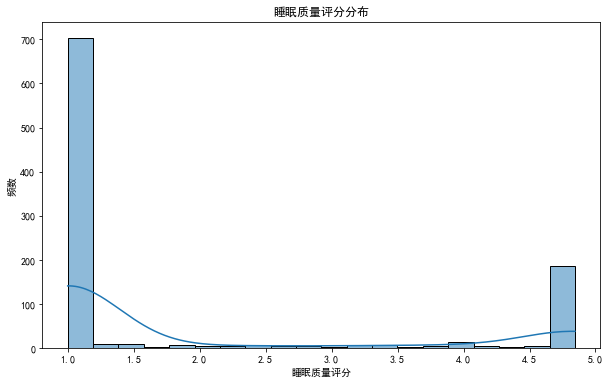

In [24]:
#可视化分析
plt.figure(figsize=(10, 6))
sns.histplot(df['睡眠质量评分'], kde=True, bins=20)
plt.title('睡眠质量评分分布')
plt.xlabel('睡眠质量评分')
plt.ylabel('频数')
plt.show()

In [25]:
#相关性分析
corr_matrix = df.corr()
sleep_corr = corr_matrix['睡眠质量评分'].sort_values(ascending=False)
print("\n睡眠质量相关性排序:")
print(sleep_corr)


睡眠质量相关性排序:
睡眠质量评分        1.000000
睡眠效率          0.665672
睡眠时长(小时)      0.045143
心率变异性         0.018890
昼夜节律偏差        0.013742
光照暴露时间(小时)   -0.020253
体温           -0.022415
压力水平         -0.046840
睡眠期间移动       -0.053592
就寝时间一致性      -0.080539
压力咖啡因交互      -0.611593
咖啡因摄入量(mg)   -0.745132
Name: 睡眠质量评分, dtype: float64


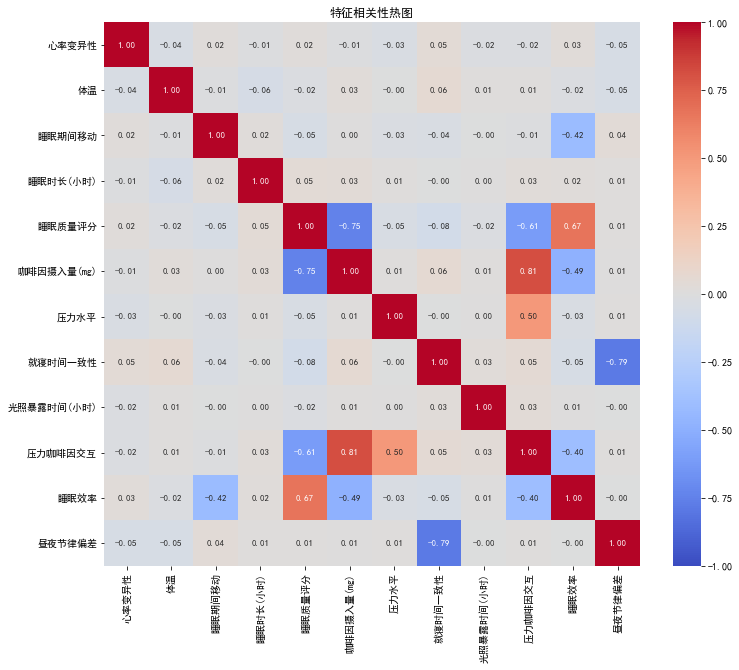

In [26]:
#相关性热图
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            annot_kws={"size": 9}, vmin=-1, vmax=1)
plt.title('特征相关性热图')
plt.show()

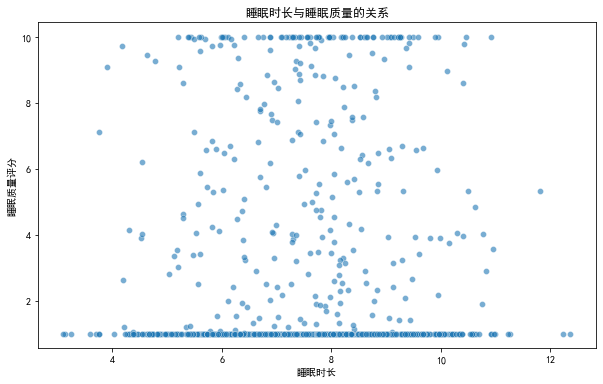

In [16]:
# 创建散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['睡眠时长(小时)'], 
                y=df['睡眠质量评分'], 
                alpha=0.6)
plt.title('睡眠时长与睡眠质量的关系')
plt.xlabel('睡眠时长')
plt.ylabel('睡眠质量评分')
plt.show()

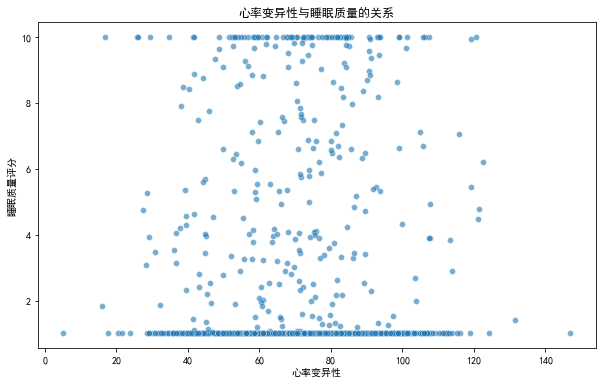

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['心率变异性'], 
                y=df['睡眠质量评分'], 
                alpha=0.6)
plt.title('心率变异性与睡眠质量的关系')
plt.xlabel('心率变异性')
plt.ylabel('睡眠质量评分')
plt.show()

In [27]:
# 创建睡眠质量分类
df['睡眠质量类别'] = pd.cut(df['睡眠质量评分'], 
                         bins=[0, 3, 7, 10],
                         labels=['差', '中等', '好'])

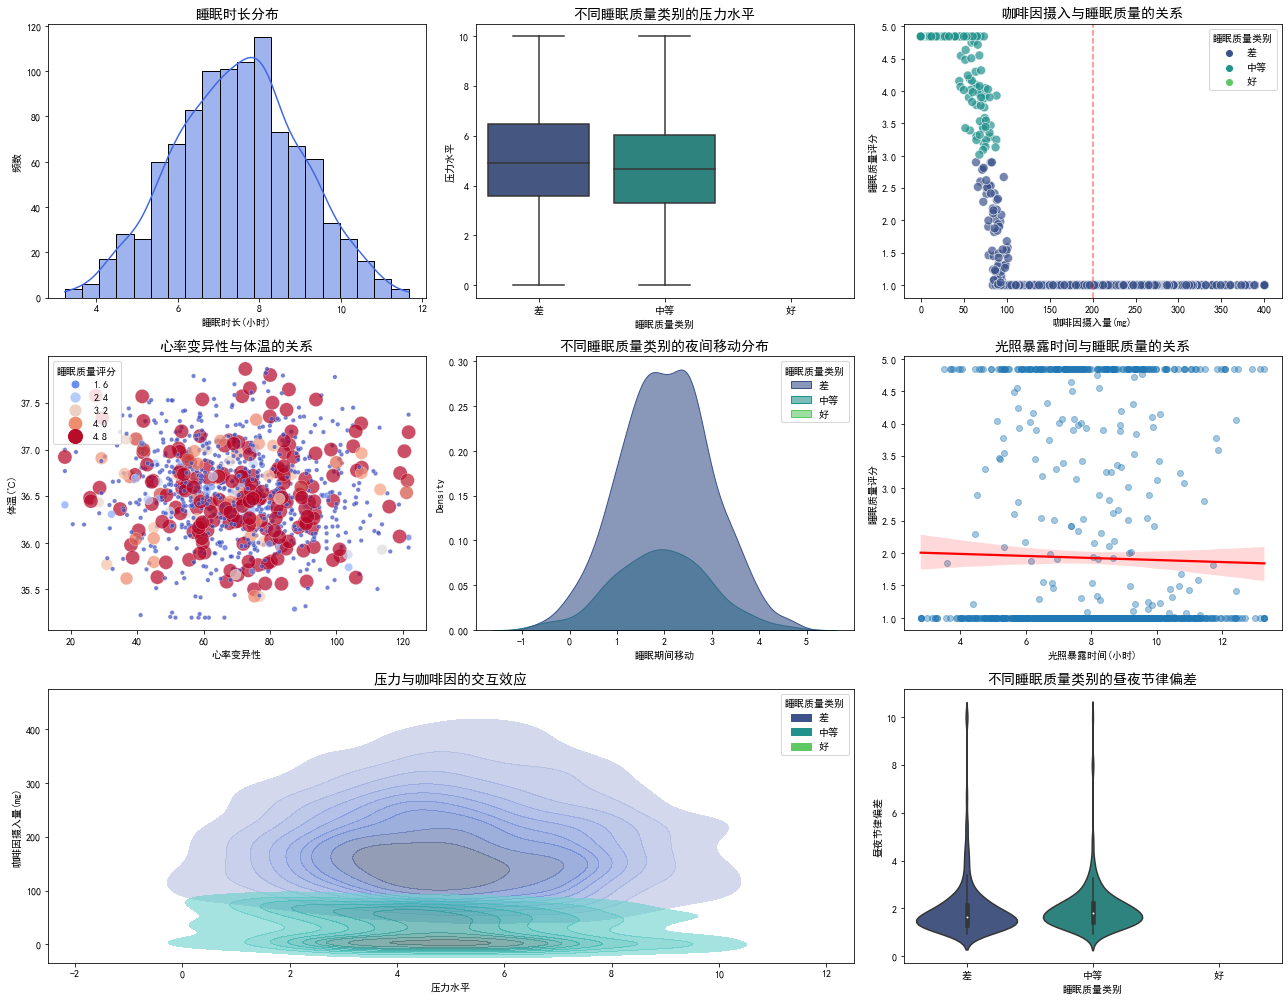

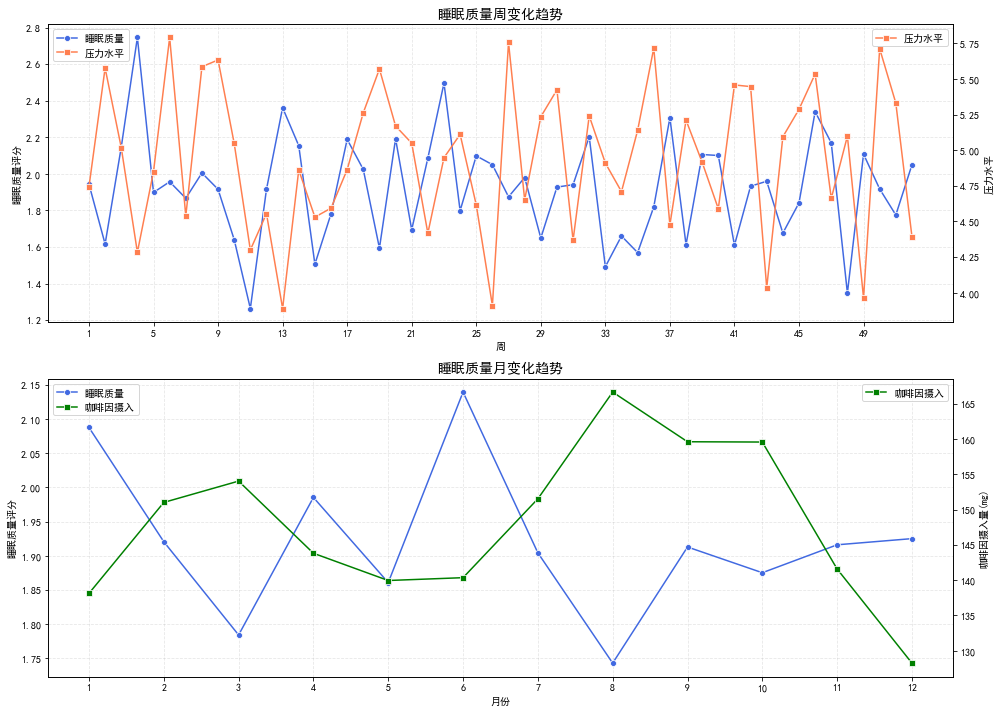

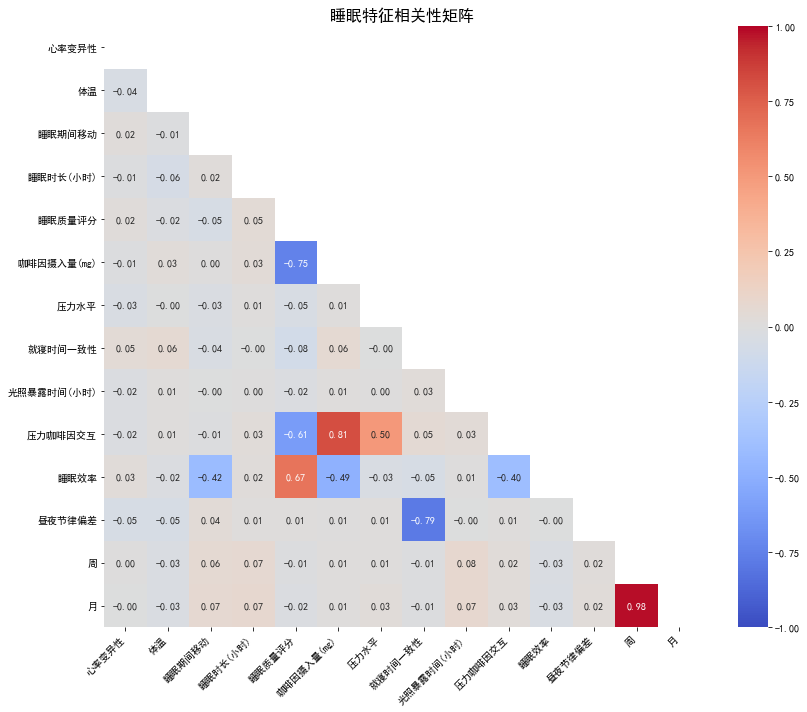

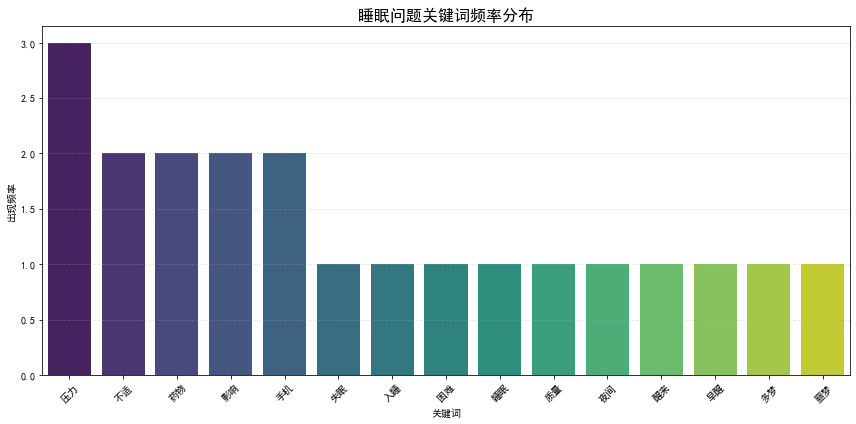

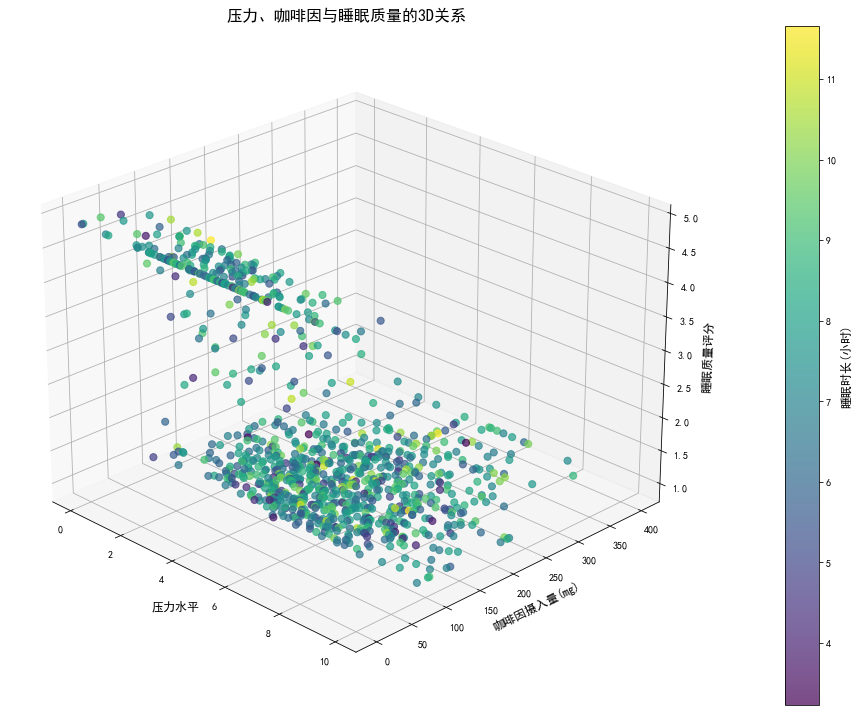

ValueError: x and y must have same first dimension, but have shapes (7,) and (6,)

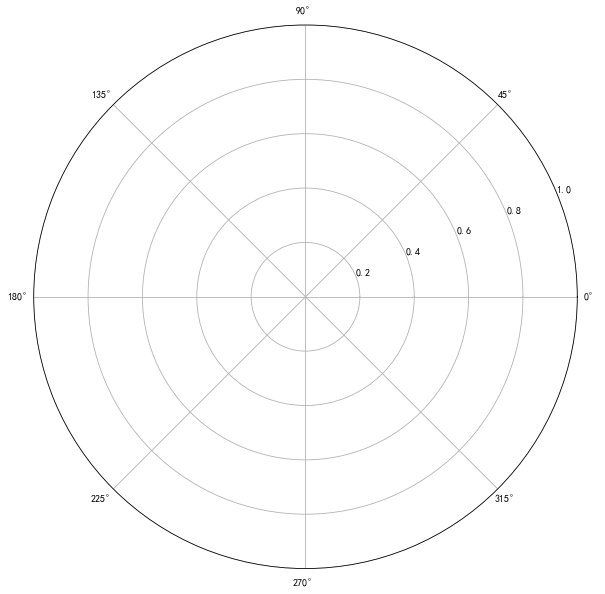

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from wordcloud import WordCloud
from PIL import Image
from collections import Counter
import matplotlib.gridspec as gridspec

# 1. 睡眠质量多维度分析（使用网格布局）
plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(3, 3)

# 1.1 睡眠时长分布
ax1 = plt.subplot(gs[0, 0])
sns.histplot(df['睡眠时长(小时)'], bins=20, kde=True, color='royalblue')
plt.title('睡眠时长分布', fontsize=14)
plt.xlabel('睡眠时长(小时)')
plt.ylabel('频数')

# 1.2 压力水平与睡眠质量
ax2 = plt.subplot(gs[0, 1])
sns.boxplot(x='睡眠质量类别', y='压力水平', data=df, palette='viridis')
plt.title('不同睡眠质量类别的压力水平', fontsize=14)
plt.xlabel('睡眠质量类别')
plt.ylabel('压力水平')

# 1.3 咖啡因摄入与睡眠质量
ax3 = plt.subplot(gs[0, 2])
sns.scatterplot(x='咖啡因摄入量(mg)', y='睡眠质量评分', 
                hue='睡眠质量类别', data=df, palette='viridis', 
                s=80, alpha=0.7)
plt.title('咖啡因摄入与睡眠质量的关系', fontsize=14)
plt.xlabel('咖啡因摄入量(mg)')
plt.ylabel('睡眠质量评分')
plt.axvline(x=200, color='r', linestyle='--', alpha=0.5)

# 1.4 心率变异性与体温
ax4 = plt.subplot(gs[1, 0])
sns.scatterplot(x='心率变异性', y='体温', 
                size='睡眠质量评分', hue='睡眠质量评分',
                sizes=(20, 200), palette='coolwarm', 
                alpha=0.7, data=df)
plt.title('心率变异性与体温的关系', fontsize=14)
plt.xlabel('心率变异性')
plt.ylabel('体温(℃)')

# 1.5 睡眠期间移动分布
ax5 = plt.subplot(gs[1, 1])
sns.kdeplot(data=df, x='睡眠期间移动', hue='睡眠质量类别', 
            fill=True, palette='viridis', alpha=0.6)
plt.title('不同睡眠质量类别的夜间移动分布', fontsize=14)
plt.xlabel('睡眠期间移动')

# 1.6 光照暴露时间与睡眠质量
ax6 = plt.subplot(gs[1, 2])
sns.regplot(x='光照暴露时间(小时)', y='睡眠质量评分', 
            data=df, scatter_kws={'alpha':0.4}, 
            line_kws={'color':'red'})
plt.title('光照暴露时间与睡眠质量的关系', fontsize=14)
plt.xlabel('光照暴露时间(小时)')
plt.ylabel('睡眠质量评分')

# 1.7 压力-咖啡因交互效应
ax7 = plt.subplot(gs[2, 0:2])
sns.kdeplot(data=df, x='压力水平', y='咖啡因摄入量(mg)', 
            hue='睡眠质量类别', fill=True, 
            palette='viridis', alpha=0.6)
plt.title('压力与咖啡因的交互效应', fontsize=14)
plt.xlabel('压力水平')
plt.ylabel('咖啡因摄入量(mg)')

# 1.8 昼夜节律偏差
ax8 = plt.subplot(gs[2, 2])
sns.violinplot(x='睡眠质量类别', y='昼夜节律偏差', 
               data=df, palette='viridis')
plt.title('不同睡眠质量类别的昼夜节律偏差', fontsize=14)
plt.xlabel('睡眠质量类别')
plt.ylabel('昼夜节律偏差')

plt.tight_layout()
plt.savefig('睡眠质量多维度分析.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. 时间序列分析（模拟按日期变化）
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=len(df), freq='D')
df['日期'] = dates

# 创建周和月特征
df['周'] = df['日期'].dt.isocalendar().week
df['月'] = df['日期'].dt.month

# 按周和月聚合
weekly_data = df.groupby('周').agg({
    '睡眠质量评分': 'mean',
    '睡眠时长(小时)': 'mean',
    '压力水平': 'mean'
}).reset_index()

monthly_data = df.groupby('月').agg({
    '睡眠质量评分': 'mean',
    '咖啡因摄入量(mg)': 'mean',
    '光照暴露时间(小时)': 'mean'
}).reset_index()

# 2.1 按周变化趋势
plt.figure(figsize=(14, 10))

ax1 = plt.subplot(2, 1, 1)
sns.lineplot(data=weekly_data, x='周', y='睡眠质量评分', 
             marker='o', color='royalblue', label='睡眠质量')
plt.title('睡眠质量周变化趋势', fontsize=14)
plt.ylabel('睡眠质量评分')
plt.xticks(range(1, 53, 4))
plt.grid(True, linestyle='--', alpha=0.3)

ax2 = ax1.twinx()
sns.lineplot(data=weekly_data, x='周', y='压力水平', 
             marker='s', color='coral', label='压力水平')
plt.ylabel('压力水平')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 2.2 按月变化趋势
ax3 = plt.subplot(2, 1, 2)
sns.lineplot(data=monthly_data, x='月', y='睡眠质量评分', 
             marker='o', color='royalblue', label='睡眠质量')
plt.title('睡眠质量月变化趋势', fontsize=14)
plt.xlabel('月份')
plt.ylabel('睡眠质量评分')
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.3)

ax4 = ax3.twinx()
sns.lineplot(data=monthly_data, x='月', y='咖啡因摄入量(mg)', 
             marker='s', color='green', label='咖啡因摄入')
plt.ylabel('咖啡因摄入量(mg)')

lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc='upper left')

plt.tight_layout()
plt.savefig('睡眠质量时间趋势.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. 相关性矩阵图
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
            cmap='coolwarm', vmin=-1, vmax=1, 
            annot_kws={"size": 10})
plt.title('睡眠特征相关性矩阵', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('睡眠特征相关性矩阵.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. 睡眠问题关键词频率分布
top_words = word_freq.most_common(15)
words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title('睡眠问题关键词频率分布', fontsize=16)
plt.xlabel('关键词')
plt.ylabel('出现频率')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('睡眠问题关键词频率.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. 睡眠质量与生活习惯的3D关系
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# 提取数据
x = df['压力水平']
y = df['咖啡因摄入量(mg)']
z = df['睡眠质量评分']
c = df['睡眠时长(小时)']

# 创建3D散点图
scatter = ax.scatter(x, y, z, c=c, cmap='viridis', s=50, alpha=0.7)

# 设置标签
ax.set_xlabel('压力水平', fontsize=12)
ax.set_ylabel('咖啡因摄入量(mg)', fontsize=12)
ax.set_zlabel('睡眠质量评分', fontsize=12)
ax.set_title('压力、咖啡因与睡眠质量的3D关系', fontsize=16)

# 添加颜色条
cbar = fig.colorbar(scatter, pad=0.1)
cbar.set_label('睡眠时长(小时)', fontsize=12)

# 调整视角
ax.view_init(elev=25, azim=-45)

plt.tight_layout()
plt.savefig('睡眠质量3D分析.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. 睡眠质量影响因素雷达图
categories = ['压力水平', '咖啡因摄入量(mg)', '睡眠期间移动', 
             '就寝时间一致性', '光照暴露时间(小时)']

# 计算每个类别的平均值（标准化）
poor_sleep = df[df['睡眠质量类别'] == '差'][categories].mean().values
good_sleep = df[df['睡眠质量类别'] == '好'][categories].mean().values

# 标准化数据
max_values = df[categories].max().values
poor_sleep = poor_sleep / max_values
good_sleep = good_sleep / max_values

# 闭合雷达图
poor_sleep = np.append(poor_sleep, poor_sleep[0])
good_sleep = np.append(good_sleep, good_sleep[0])
categories = np.append(categories, categories[0])

# 设置角度
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

# 创建雷达图
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.plot(angles, poor_sleep, 'o-', linewidth=2, label='睡眠质量差', color='coral')
ax.fill(angles, poor_sleep, alpha=0.25, color='coral')
ax.plot(angles, good_sleep, 'o-', linewidth=2, label='睡眠质量好', color='royalblue')
ax.fill(angles, good_sleep, alpha=0.25, color='royalblue')

# 设置标签
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories[:-1], fontsize=12)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["20%", "40%", "60%", "80%"], color="grey", size=10)
plt.ylim(0, 1)

plt.title('睡眠质量影响因素雷达图', size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig('睡眠质量影响因素雷达图.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
#保存处理后的中文数据
df.to_csv('processed_sleep_data_chinese.csv', index=False, encoding='utf-8-sig')
print("\n处理后的数据已保存为 'processed_sleep_data_chinese.csv'")


处理后的数据已保存为 'processed_sleep_data_chinese.csv'


In [6]:
#数据预处理
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据加载与概况分析
def load_and_analyze_data():
    # 加载数据
    df = pd.read_csv("wearable_tech_sleep_quality_1.csv")
    
    # 数据概况分析
    print("="*50)
    print("数据集概况:")
    print(f"样本数量: {df.shape[0]}")
    print(f"特征数量: {df.shape[1]}")
    print("\n特征类型分布:")
    print(df.dtypes.value_counts())
    
    # 描述性统计
    print("\n描述性统计:")
    print(df.describe().T)
    
    # 缺失值分析
    print("\n缺失值分析:")
    missing_df = pd.DataFrame({
        '缺失数量': df.isnull().sum(),
        '缺失比例': df.isnull().mean().round(4)
    })
    print(missing_df[missing_df['缺失数量'] > 0])
    
    return df

In [7]:
# 2. 数据预处理
def preprocess_data(df):
    # 复制数据框
    df_clean = df.copy()
    
    # 缺失值处理
    print("\n" + "="*50)
    print("缺失值处理:")
    
    # 数值型特征 - 使用随机森林填充缺失率高的特征
    numeric_cols = df_clean.select_dtypes(include=np.number).columns
    
    # 对于缺失率较高的特征使用随机森林填充
    high_missing_cols = missing_df[missing_df['缺失比例'] > 0.05].index
    for col in high_missing_cols:
        if col in numeric_cols:
            # 提取非缺失值的行
            non_missing = df_clean[~df_clean[col].isnull()]
            missing = df_clean[df_clean[col].isnull()]
            
            if len(non_missing) > 0 and len(missing) > 0:
                # 选择其他特征作为预测变量
                features = numeric_cols.drop(col)
                
                # 分割训练集和预测集
                X_train = non_missing[features]
                y_train = non_missing[col]
                X_pred = missing[features]
                
                # 训练随机森林模型
                rf = RandomForestRegressor(n_estimators=100, random_state=42)
                rf.fit(X_train, y_train)
                
                # 预测缺失值
                df_clean.loc[df_clean[col].isnull(), col] = rf.predict(X_pred)
                print(f"使用随机森林填充了 {col} 的 {len(missing)} 个缺失值")
    
    # 使用中位数填充其他数值型特征的缺失值
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            missing_count = df_clean[col].isnull().sum()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"使用中位数填充了 {col} 的 {missing_count} 个缺失值")
    
    # 异常值处理
    print("\n" + "="*50)
    print("异常值处理:")
    
    # IQR方法处理异常值
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 识别异常值
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        
        if len(outliers) > 0:
            # 替换异常值为边界值
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
            print(f"使用IQR方法处理了 {col} 中的 {len(outliers)} 个异常值")
    
    # 特征工程
    print("\n" + "="*50)
    print("特征工程:")
    
    # 创建交互特征
    df_clean['Stress_Caffeine_Interaction'] = df_clean['Stress_Level'] * df_clean['Caffeine_Intake_mg']
    print("创建交互特征: Stress_Level * Caffeine_Intake_mg")
    
    # 创建睡眠效率指标 (假设Movement_During_Sleep与睡眠质量成反比)
    df_clean['Sleep_Efficiency'] = df_clean['Sleep_Quality_Score'] / (df_clean['Movement_During_Sleep'] + 1)
    print("创建特征: Sleep_Efficiency")
    
    # 创建昼夜节律偏差指标 (假设Bedtime_Consistency与睡眠质量成正比)
    df_clean['Circadian_Rhythm_Deviation'] = 1 / (df_clean['Bedtime_Consistency'] + 0.1)
    print("创建特征: Circadian_Rhythm_Deviation")
    
    return df_clean

In [9]:
# 4. 相关性分析
def correlation_analysis(df):
    print("\n" + "="*50)
    print("相关性分析:")
    
    # 计算相关系数矩阵
    corr_matrix = df.corr()
    
    # 睡眠质量的相关性排序
    sleep_corr = corr_matrix['Sleep_Quality_Score'].sort_values(ascending=False)
    print("\n睡眠质量相关性排序:")
    print(sleep_corr)
    
    # 相关性热图
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                annot_kws={"size": 9}, vmin=-1, vmax=1)
    plt.title('特征相关性热图')
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 睡眠质量与主要特征的相关性
    top_features = sleep_corr.index[1:6]  # 排除自身相关性
    bottom_features = sleep_corr.index[-5:]
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    # 正相关特征
    sns.barplot(x=top_features, y=sleep_corr[top_features], ax=ax[0], palette='viridis')
    ax[0].set_title('与睡眠质量正相关性最强的特征')
    ax[0].set_ylabel('相关系数')
    
    # 负相关特征
    sns.barplot(x=bottom_features, y=sleep_corr[bottom_features], ax=ax[1], palette='viridis')
    ax[1].set_title('与睡眠质量负相关性最强的特征')
    ax[1].set_ylabel('相关系数')
    
    plt.tight_layout()
    plt.savefig('top_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return corr_matrix

# 主函数
def main():
    # 1. 数据加载与概况分析
    df = load_and_analyze_data()
    
    # 2. 数据预处理
    df_clean = preprocess_data(df)
    
    # 3. 可视化分析
    visualize_data(df_clean)
    
    # 4. 相关性分析
    corr_matrix = correlation_analysis(df_clean)
    
    # 保存处理后的数据
    df_clean.to_csv('processed_sleep_data.csv', index=False)
    print("\n处理后的数据已保存为 'processed_sleep_data.csv'")

if __name__ == "__main__":
    main()